In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Completed Sudoku Puzzles: https://www.kaggle.com/datasets/bryanpark/sudoku

In [40]:
import numpy as np

solutions_9by9 = np.zeros((10000, 81), np.int32)
for i, line in enumerate(open('sudoku.csv', 'r').read().splitlines()[1:]):
    if i >= solutions_9by9.shape[0]:
        break

    quiz, solution = line.split(",")
    for j, q_s in enumerate(zip(quiz, solution)):
        q, s = q_s
        solutions_9by9[i, j] = s

solutions_9by9 = solutions_9by9.reshape((-1, 9, 9))

In [41]:
solutions_6by6 = solutions_9by9[:,:6,:6]

In [42]:
SIZE = 9

In [43]:
if SIZE == 9:
    solutions = solutions_9by9
elif SIZE == 6:
    solutions = solutions_6by6

In [44]:
num_train = 10000

In [45]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from torch.nn import Flatten
import torch

import random

transform = transforms.Compose([transforms.ToTensor(),
                          transforms.Normalize((0.5,), (0.5,)),
                          Flatten(0)
                          ])
trainset = datasets.MNIST('data', download=True, train=True, transform=transform)
testset = datasets.MNIST('data', download=True, train=False, transform=transform)

train_ids = random.sample(range(0, 50000), num_train)

In [46]:
class SudokuDataset(Dataset):
    def __init__(self, dataset, digit_ids, solutions):
        self.dataset = dataset
        
        self.digit_to_id = {}

        for d in range(10):
            self.digit_to_id[d] = []

        for d_id in digit_ids:
            self.digit_to_id[dataset[d_id][1]].append(d_id)
    
        print('num digit_ids: ', len(digit_ids))
        print('solutions: ', len(solutions))
        
        
        self.solution_image_ids = torch.empty((solutions.shape[0],
                                               solutions.shape[1] ** 2), dtype=torch.int32) # n x 36 or 81
        for i, sol in enumerate(solutions):
            for j, digit in enumerate(sol.flatten()):
                self.solution_image_ids[i, j] = self.get_id_from_digit(digit)

    def get_id_from_digit(self, digit):
        return random.sample(self.digit_to_id[digit], 1)[0]
    
    def __len__(self):
        return self.solution_image_ids.shape[0]
    
    def __getitem__(self, idx):
        digit_ids = self.solution_image_ids[idx]
        
        images = torch.empty((self.solution_image_ids.shape[1], 28 * 28))
        labels = torch.empty((self.solution_image_ids.shape[1],))
        
        for i, d_id in enumerate(digit_ids):
            images[i] = self.dataset[d_id][0]
            labels[i] = self.dataset[d_id][1]
        
        images = torch.unsqueeze(images, dim=0)
        labels = torch.unsqueeze(labels, dim=0)
        
        return {'images': images, 'labels': labels}
    
s_data = SudokuDataset(trainset, train_ids, solutions[:1000])


num digit_ids:  10000
solutions:  1000


In [47]:
from matplotlib import pyplot as plt

def viz(images):
    plt.figure(figsize=(10, 10))
    
    fig, axes = plt.subplots(SIZE, SIZE)
    
    for ax, img in zip(axes.flatten(), images[0]):
        ax.imshow(img.reshape(28, 28))
        ax.set_yticklabels([])
        ax.set_xticklabels([])

In [48]:
s_data[0]['labels'].shape

torch.Size([1, 81])

<Figure size 720x720 with 0 Axes>

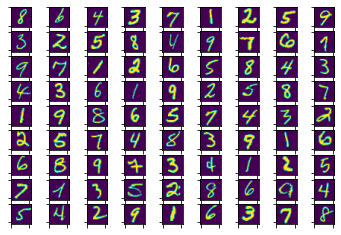

In [49]:
viz(s_data[0]['images'])

In [50]:
import sys
sys.path.append('../../')

import logging
logging.basicConfig(level=logging.INFO)

from regr.graph import Graph, Concept, Relation
from regr.graph.logicalConstrain import andL, existsL, notL, atMostL, ifL, fixedL, eqL, exactL
from regr.graph import EnumConcept
from regr.sensor.pytorch.sensors import JointSensor, ReaderSensor, FunctionalSensor
from regr.sensor.pytorch.learners import ModuleLearner

In [51]:
Graph.clear()
Concept.clear()
Relation.clear()

with Graph('global') as graph:
    sudoku = Concept("sodoku")
    
    empty_entry = Concept(name='empty_entry')
    (empty_rel, ) = sudoku.contains(empty_entry)
    
    same_row = Concept(name="same_row")
    (same_row_arg1, same_row_arg2) = same_row.has_a(row1=empty_entry, row2=empty_entry)
    
    same_col = Concept(name="same_col")
    (same_col_arg1, same_col_arg2) = same_col.has_a(col1=empty_entry, col2=empty_entry)
    
    same_table = Concept(name="same_table")
    (same_table_arg1, same_table_arg2) = same_table.has_a(table1=empty_entry, table2=empty_entry)
    
    empty_entry_label = empty_entry(name="empty_entry_label", ConceptClass=EnumConcept, 
                                    values=[f'v{d}' for d in range(SIZE)])
    v = [getattr(empty_entry_label, a) for a in ('', *empty_entry_label.enum)]

    for row_num in range(SIZE):
        for j in range(1, SIZE + 1):
            exactL(v[j](path = (eqL(empty_entry, "rows", {row_num}))))
            exactL(v[j](path = (eqL(empty_entry, "cols", {row_num}))))
            exactL(v[j](path = (eqL(empty_entry, "tables", {row_num}))))

/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('row1', 'empty_entry'), ('row2', 'empty_entry')]) is used.
  if sys.path[0] == '':
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('col1', 'empty_entry'), ('col2', 'empty_entry')]) is used.
  from ipykernel import kernelapp as app
/Users/alexanderwan/miniconda3/envs/domiknows/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Please use OrderedDict rather than dict to prevent unpredictable order of arguments.For this instance, OrderedDict([('table1', 'empty_entry'), ('table2', 'empty_entry')]) is used.


In [52]:
cols_indices = torch.arange(SIZE).repeat((SIZE, 1)).flatten()
rows_indices = torch.arange(SIZE).repeat((SIZE, 1)).T.flatten()
cols_indices = cols_indices.unsqueeze(-1) # 81 x 1
rows_indices = rows_indices.unsqueeze(-1) # 81 x 1

tables_indices = torch.empty((SIZE, SIZE))

for i in range(0, SIZE, 3):
    for j in range(0, SIZE, 3):
        tables_indices[i:i+3, j:j+3] = i + j//3

tables_indices = tables_indices.flatten().unsqueeze(-1) # 81 x 1

In [53]:
from cnn import Net

In [54]:
sudoku['images'] = ReaderSensor(keyword='images') # 1 x 81 x 784
sudoku['all_logits'] = ModuleLearner('images', module=Net(SIZE)) # 1 x 81 x 9

sudoku['labels'] = ReaderSensor(keyword='labels') # 1 x 81

In [55]:
def unpack(logits):
    return torch.ones((SIZE ** 2,)), rows_indices.squeeze(), cols_indices.squeeze(), tables_indices.squeeze(0), logits[0]


In [56]:
empty_entry[empty_rel, 'rows', 'cols', 'tables', 'logits'] = JointSensor(sudoku['all_logits'],
                                                                         forward=unpack)

In [57]:
def constant(x):
    return x

In [58]:
empty_entry[empty_entry_label] = FunctionalSensor('logits', forward=constant)

In [59]:
# sanity check
#empty_entry[empty_entry_label] = FunctionalSensor('label', forward=lambda x: torch.unsqueeze(x, dim=0), label=True)

In [60]:
from regr.program import SolverPOIProgram
from regr.program.metric import MacroAverageTracker
from regr.program.loss import NBCrossEntropyLoss

'''program = SolverPOIProgram(
        graph,
        poi=(sudoku, empty_entry, same_row, same_col, same_table),
        inferTypes=['local/argmax'],
        loss=MacroAverageTracker(NBCrossEntropyLoss()),
)'''

"program = SolverPOIProgram(\n        graph,\n        poi=(sudoku, empty_entry, same_row, same_col, same_table),\n        inferTypes=['local/argmax'],\n        loss=MacroAverageTracker(NBCrossEntropyLoss()),\n)"

In [61]:
from regr.program.lossprogram import SampleLossProgram, PrimalDualProgram
from regr.program.model.pytorch import SolverModel

'''class CallbackProgram(SampleLossProgram):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.after_train_epoch = []

    def call_epoch(self, name, dataset, epoch_fn, **kwargs):
        if name == 'Testing':
            for fn in self.after_train_epoch:
                fn(kwargs)
        else:
            super().call_epoch(name, dataset, epoch_fn, **kwargs)


program = CallbackProgram(graph, SolverModel,
                    poi=(sudoku, empty_entry, same_row, same_col, same_table),
                    inferTypes=['local/argmax'],
                    sample=True,
                    sampleSize=2000,
                    sampleGlobalLoss=True,
                    beta=1)'''


"class CallbackProgram(SampleLossProgram):\n    def __init__(self, *args, **kwargs):\n        super().__init__(*args, **kwargs)\n        self.after_train_epoch = []\n\n    def call_epoch(self, name, dataset, epoch_fn, **kwargs):\n        if name == 'Testing':\n            for fn in self.after_train_epoch:\n                fn(kwargs)\n        else:\n            super().call_epoch(name, dataset, epoch_fn, **kwargs)\n\n\nprogram = CallbackProgram(graph, SolverModel,\n                    poi=(sudoku, empty_entry, same_row, same_col, same_table),\n                    inferTypes=['local/argmax'],\n                    sample=True,\n                    sampleSize=2000,\n                    sampleGlobalLoss=True,\n                    beta=1)"

In [62]:
class CallbackProgram(PrimalDualProgram):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.after_train_epoch = []

    def call_epoch(self, name, dataset, epoch_fn, **kwargs):
        if name == 'Testing':
            for fn in self.after_train_epoch:
                fn(kwargs)
        else:
            super().call_epoch(name, dataset, epoch_fn, **kwargs)


program = CallbackProgram(graph, SolverModel,
                    poi=(sudoku, empty_entry, same_row, same_col, same_table),
                    inferTypes=['local/argmax'])

In [63]:
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

def get_classification_report(dataloader, sample_num=10, limit=100, infer_suffixes=['/ILP', '/local/argmax']):
    pred_results = {}
    
    for suffix in infer_suffixes:
        pred_results[suffix] = []
    
    labels_all = []

    for d_idx, node in tqdm(enumerate(program.populate(dataloader)), total=min(limit, len(dataloader))):
        if d_idx >= limit:
            break

        node.inferILPResults()
        
        labels = node.getAttribute('labels')
        labels_all.extend(labels.tolist()[0])
        
        for suffix in infer_suffixes:
            preds = torch.empty((SIZE ** 2))

            for i, entry in enumerate(node.getChildDataNodes(conceptName=empty_entry)):
                entry_pred = torch.argmax(entry.getAttribute('<empty_entry_label>' + suffix), dim=0)

                preds[i] = entry_pred

            pred_results[suffix].extend(preds.tolist())

            if d_idx < sample_num:
                print(suffix)
                
                print(preds.reshape(SIZE, SIZE))

                print(labels.reshape(SIZE, SIZE))

                print('\n')

        if d_idx < sample_num:
            print("===========================")

    for suffix, preds in pred_results.items():
        print("========= %s =========" % suffix)
        print(classification_report(labels_all, preds))
        print("===========================")

def post_epoch_metrics(kwargs):
    get_classification_report(trainloader)

In [64]:
program.after_train_epoch = [post_epoch_metrics]

In [65]:
trainloader = DataLoader(
    s_data,
    shuffle=False
)

In [66]:
optim = lambda param: torch.optim.Adam(param, lr=0.05)

In [ ]:
program.train(trainloader,
              train_epoch_num=10,
              Optim=optim,
              device='auto',
              test_every_epoch=True,
              c_warmup_iters=0
             )

INFO:regr.program.program:Epoch: 1
INFO:regr.program.program:Training:
Epoch 1 Training:   0%|          | 0/1000 [00:00<?, ?it/s]

multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v0', 0, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(0), 'cols': tensor(0), 'tables': tensor([0.]), 'logits': tensor([-0.1333,  0.2306,  0.1212,  0.2368,  0.1275,  0.1391, -0.0634, -0.0136,
         0.1405], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.1333,  0.2306,  0.1212,  0.2368,  0.1275,  0.1391, -0.0634, -0.0136,
         0.1405], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0885, 0.1273, 0.1141, 0.1281, 0.1148, 0.1162, 0.0949, 0.0997, 0.1163],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.0885, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v0', 0, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(0), 'cols': tensor(1), 'tables': tenso

(tensor(0.1281, grad_fn=<SelectBackward>), tensor(0.1228, grad_fn=<SelectBackward>), tensor(0.1245, grad_fn=<SelectBackward>), tensor(0.1368, grad_fn=<SelectBackward>), tensor(0.1356, grad_fn=<SelectBackward>), tensor(0.1272, grad_fn=<SelectBackward>), tensor(0.1254, grad_fn=<SelectBackward>), tensor(0.1259, grad_fn=<SelectBackward>), tensor(0.1213, grad_fn=<SelectBackward>))
var [tensor(0.1281, grad_fn=<SelectBackward>), tensor(0.1228, grad_fn=<SelectBackward>), tensor(0.1245, grad_fn=<SelectBackward>), tensor(0.1368, grad_fn=<SelectBackward>), tensor(0.1356, grad_fn=<SelectBackward>), tensor(0.1272, grad_fn=<SelectBackward>), tensor(0.1254, grad_fn=<SelectBackward>), tensor(0.1259, grad_fn=<SelectBackward>), tensor(0.1213, grad_fn=<SelectBackward>)]
tensor(1.1476, grad_fn=<AddBackward0>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v3', 3, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(0), 'cols': tensor(0), 'tables':

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(0), 'cols': tensor(5), 'tables': tensor([1.]), 'logits': tensor([-0.1405, -0.0420,  0.0406,  0.2694,  0.1082,  0.3606, -0.0417,  0.0596,
         0.2811], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.1405, -0.0420,  0.0406,  0.2694,  0.1082,  0.3606, -0.0417,  0.0596,
         0.2811], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0863, 0.0952, 0.1034, 0.1300, 0.1106, 0.1424, 0.0952, 0.1054, 0.1315],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.1054, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v7', 7, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(0), 'cols': tensor(6), 'tables': tensor([2.]), 'logits': tensor([-0.1620,  0.1111,  0.1741,  0.3525,  0.2578,  0.2188,  0.0444, -0.0483,
       

multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v1', 1, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(0), 'cols': tensor(3), 'tables': tensor([1.]), 'logits': tensor([ 0.0260, -0.0292,  0.1635,  0.1975,  0.2539,  0.3162, -0.0624,  0.0924,
         0.1008], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([ 0.0260, -0.0292,  0.1635,  0.1975,  0.2539,  0.3162, -0.0624,  0.0924,
         0.1008], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.1007, 0.0952, 0.1155, 0.1195, 0.1264, 0.1345, 0.0921, 0.1076, 0.1085],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.0952, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v1', 1, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(0), 'cols': tensor(4), 'tables': tenso

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(1), 'cols': tensor(4), 'tables': tensor([1.]), 'logits': tensor([-0.0644, -0.0077,  0.0893,  0.2369,  0.2088,  0.1838,  0.1750,  0.1004,
         0.2824], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.0644, -0.0077,  0.0893,  0.2369,  0.2088,  0.1838,  0.1750,  0.1004,
         0.2824], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0906, 0.0959, 0.1057, 0.1225, 0.1191, 0.1161, 0.1151, 0.1068, 0.1282],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.], grad_fn=<CopySlices>)}
tensor(0.1161, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v5', 5, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(1), 'cols': tensor(5), 'tables': tensor([1.]), 'logits': tensor([-0.1650,  0.2000,  0.3257,  0.3211,  0.2316,  0.2729,  0.0849,  0.0199,
       

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(8), 'cols': tensor(1), 'tables': tensor([6.]), 'logits': tensor([-0.2103,  0.2654,  0.2093,  0.2456,  0.3012,  0.2310, -0.0125,  0.1121,
         0.2248], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.2103,  0.2654,  0.2093,  0.2456,  0.3012,  0.2310, -0.0125,  0.1121,
         0.2248], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0765, 0.1231, 0.1164, 0.1207, 0.1276, 0.1189, 0.0932, 0.1056, 0.1182],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.1182, grad_fn=<SelectBackward>)
{'V0': [[], [tensor(0.1306, grad_fn=<SelectBackward>)], [], [], [], [], [], [], [], [], [tensor(0.1248, grad_fn=<SelectBackward>)], [], [], [], [], [], [], [], [], [tensor(0.1312, grad_fn=<SelectBackward>)], [], [], [], [], [], [], [], [], [tensor(0.1239, grad_fn=<SelectBackward>)], [], [], [], [], [], [], [],

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(2), 'cols': tensor(2), 'tables': tensor([0.]), 'logits': tensor([-0.3224,  0.2226,  0.2083,  0.3383,  0.2533,  0.1510, -0.0787, -0.0143,
         0.3507], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.3224,  0.2226,  0.2083,  0.3383,  0.2533,  0.1510, -0.0787, -0.0143,
         0.3507], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0697, 0.1203, 0.1185, 0.1350, 0.1240, 0.1119, 0.0890, 0.0949, 0.1367],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.], grad_fn=<CopySlices>)}
tensor(0.1350, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v3', 3, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(2), 'cols': tensor(3), 'tables': tensor([1.]), 'logits': tensor([-0.0963,  0.1079, -0.0022,  0.0376,  0.2900,  0.0623, -0.0869,  0.1658,
       

(tensor(0.1079, grad_fn=<SelectBackward>), tensor(0.0940, grad_fn=<SelectBackward>), tensor(0.0890, grad_fn=<SelectBackward>), tensor(0.0983, grad_fn=<SelectBackward>), tensor(0.0913, grad_fn=<SelectBackward>), tensor(0.1016, grad_fn=<SelectBackward>), tensor(0.1020, grad_fn=<SelectBackward>), tensor(0.0978, grad_fn=<SelectBackward>), tensor(0.0987, grad_fn=<SelectBackward>))
var [tensor(0.1079, grad_fn=<SelectBackward>), tensor(0.0940, grad_fn=<SelectBackward>), tensor(0.0890, grad_fn=<SelectBackward>), tensor(0.0983, grad_fn=<SelectBackward>), tensor(0.0913, grad_fn=<SelectBackward>), tensor(0.1016, grad_fn=<SelectBackward>), tensor(0.1020, grad_fn=<SelectBackward>), tensor(0.0978, grad_fn=<SelectBackward>), tensor(0.0987, grad_fn=<SelectBackward>)]
tensor(0.8807, grad_fn=<AddBackward0>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v6', 6, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(0), 'cols': tensor(6), 'tables':

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(3), 'cols': tensor(1), 'tables': tensor([3.]), 'logits': tensor([-0.0644, -0.0802,  0.1868,  0.3910,  0.2610,  0.4568,  0.1248, -0.0048,
         0.3006], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.0644, -0.0802,  0.1868,  0.3910,  0.2610,  0.4568,  0.1248, -0.0048,
         0.3006], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0860, 0.0847, 0.1106, 0.1356, 0.1191, 0.1449, 0.1039, 0.0913, 0.1239],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.0847, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v1', 1, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(3), 'cols': tensor(2), 'tables': tensor([3.]), 'logits': tensor([-0.0747,  0.0338,  0.1325,  0.2166,  0.1188,  0.1508, -0.0507, -0.0783,
       

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(8), 'cols': tensor(3), 'tables': tensor([7.]), 'logits': tensor([-0.1919,  0.0424,  0.1448,  0.2581,  0.1758,  0.2251, -0.0018,  0.0668,
         0.1075], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.1919,  0.0424,  0.1448,  0.2581,  0.1758,  0.2251, -0.0018,  0.0668,
         0.1075], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0830, 0.1049, 0.1162, 0.1302, 0.1199, 0.1259, 0.1004, 0.1075, 0.1120],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.1199, grad_fn=<SelectBackward>)
{'V0': [[], [], [], [tensor(0.1264, grad_fn=<SelectBackward>)], [], [], [], [], [], [], [], [], [tensor(0.1222, grad_fn=<SelectBackward>)], [], [], [], [], [], [], [], [], [tensor(0.1376, grad_fn=<SelectBackward>)], [], [], [], [], [], [], [], [], [tensor(0.1232, grad_fn=<SelectBackward>)], [], [], [], [], [],

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(3), 'cols': tensor(3), 'tables': tensor([4.]), 'logits': tensor([-0.1481,  0.0714,  0.2654,  0.2819,  0.2698,  0.3501,  0.1040,  0.0285,
         0.1835], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.1481,  0.0714,  0.2654,  0.2819,  0.2698,  0.3501,  0.1040,  0.0285,
         0.1835], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0811, 0.1010, 0.1226, 0.1246, 0.1232, 0.1334, 0.1043, 0.0967, 0.1130],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.1130, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v8', 8, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(3), 'cols': tensor(4), 'tables': tensor([4.]), 'logits': tensor([-0.0619,  0.0600,  0.0620,  0.0917,  0.2501,  0.2382, -0.0709,  0.1204,
       

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(3), 'cols': tensor(4), 'tables': tensor([4.]), 'logits': tensor([-0.0619,  0.0600,  0.0620,  0.0917,  0.2501,  0.2382, -0.0709,  0.1204,
         0.0797], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.0619,  0.0600,  0.0620,  0.0917,  0.2501,  0.2382, -0.0709,  0.1204,
         0.0797], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0954, 0.1077, 0.1079, 0.1112, 0.1303, 0.1287, 0.0945, 0.1144, 0.1099],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 1., 0., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.1079, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v2', 2, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(4), 'cols': tensor(4), 'tables': tensor([4.]), 'logits': tensor([-0.1630,  0.1042,  0.1730,  0.4336,  0.2369,  0.3002,  0.0082, -0.0216,
       

(tensor(0.1334, grad_fn=<SelectBackward>), tensor(0.1287, grad_fn=<SelectBackward>), tensor(0.1106, grad_fn=<SelectBackward>), tensor(0.1328, grad_fn=<SelectBackward>), tensor(0.1274, grad_fn=<SelectBackward>), tensor(0.1174, grad_fn=<SelectBackward>), tensor(0.1163, grad_fn=<SelectBackward>), tensor(0.1018, grad_fn=<SelectBackward>), tensor(0.1158, grad_fn=<SelectBackward>))
var [tensor(0.1334, grad_fn=<SelectBackward>), tensor(0.1287, grad_fn=<SelectBackward>), tensor(0.1106, grad_fn=<SelectBackward>), tensor(0.1328, grad_fn=<SelectBackward>), tensor(0.1274, grad_fn=<SelectBackward>), tensor(0.1174, grad_fn=<SelectBackward>), tensor(0.1163, grad_fn=<SelectBackward>), tensor(0.1018, grad_fn=<SelectBackward>), tensor(0.1158, grad_fn=<SelectBackward>)]
tensor(1.0843, grad_fn=<AddBackward0>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v6', 6, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(4), 'cols': tensor(0), 'tables':

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(3), 'cols': tensor(5), 'tables': tensor([4.]), 'logits': tensor([-0.1727,  0.0968,  0.3239,  0.4370,  0.1061,  0.1215, -0.0851, -0.0877,
         0.2344], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.1727,  0.0968,  0.3239,  0.4370,  0.1061,  0.1215, -0.0851, -0.0877,
         0.2344], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0824, 0.1079, 0.1354, 0.1516, 0.1089, 0.1106, 0.0899, 0.0897, 0.1238],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 1., 0., 0., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.0824, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v0', 0, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(4), 'cols': tensor(5), 'tables': tensor([4.]), 'logits': tensor([-0.0849,  0.0323, -0.0017,  0.1938,  0.1157,  0.0788, -0.1150, -0.1300,
       

multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v4', 4, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(5), 'cols': tensor(0), 'tables': tensor([3.]), 'logits': tensor([-0.2802,  0.0261,  0.0211,  0.2193,  0.2528,  0.3344, -0.1769,  0.0360,
         0.1665], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.2802,  0.0261,  0.0211,  0.2193,  0.2528,  0.3344, -0.1769,  0.0360,
         0.1665], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0772, 0.1049, 0.1043, 0.1272, 0.1315, 0.1427, 0.0856, 0.1059, 0.1207],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.1315, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v4', 4, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(5), 'cols': tensor(1), 'tables': tenso

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(7), 'cols': tensor(5), 'tables': tensor([7.]), 'logits': tensor([-0.2202,  0.2102,  0.1104,  0.3632,  0.2901,  0.1173,  0.0684, -0.1013,
         0.3711], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.2202,  0.2102,  0.1104,  0.3632,  0.2901,  0.1173,  0.0684, -0.1013,
         0.3711], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0766, 0.1178, 0.1066, 0.1373, 0.1276, 0.1073, 0.1022, 0.0863, 0.1384],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 0., 0., 0., 1.], grad_fn=<CopySlices>)}
tensor(0.0863, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v7', 7, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(8), 'cols': tensor(5), 'tables': tensor([7.]), 'logits': tensor([-0.0707,  0.1983,  0.1459,  0.2932,  0.0383,  0.0812,  0.1252, -0.1066,
       

{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(6), 'cols': tensor(3), 'tables': tensor([7.]), 'logits': tensor([-0.1756,  0.0772,  0.0155,  0.1344,  0.1180,  0.2123, -0.1132,  0.1215,
         0.0963], grad_fn=<UnbindBackward>), '<empty_entry_label>': tensor([-0.1756,  0.0772,  0.0155,  0.1344,  0.1180,  0.2123, -0.1132,  0.1215,
         0.0963], grad_fn=<UnbindBackward>), '<empty_entry_label>/local/softmax': tensor([0.0877, 0.1130, 0.1062, 0.1196, 0.1177, 0.1293, 0.0934, 0.1181, 0.1151],
       grad_fn=<SoftmaxBackward>), '<empty_entry_label>/local/argmax': tensor([0., 0., 0., 0., 0., 1., 0., 0., 0.], grad_fn=<CopySlices>)}
tensor(0.1062, grad_fn=<SelectBackward>)
multiclass label (EnumConcept(name='empty_entry_label', fullname='global/empty_entry_label'), 'v2', 2, 9)
{'sodoku-contains-0-empty_entry': tensor(1.), 'rows': tensor(6), 'cols': tensor(4), 'tables': tensor([7.]), 'logits': tensor([-0.1238, -0.0386,  0.0594,  0.2028,  0.2804,  0.2393,  0.1143,  0.0190,
       